In [4]:
# 导入工具包
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [19]:
# 指定好数据路径（训练和验证）
base_dir = './tmp/catdog'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
print(train_dir)
# 训练集
train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')

# 验证集
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')

./tmp/catdog\train


In [106]:
# 构建卷积神经网络模型
# 几层都可以，大家可以随意玩
# 如果用cpu训练，可以把输入设置的更小一些，一般输入大小更主要的决定了训练速度
# 后期试试GPU https://blog.csdn.net/weixin_43213607/article/details/108576900
# 没有GPU64*64就差不多了，有了可以上224*224 N卡6G
model = tf.keras.models.Sequential([
    # 如果训练慢，可以把数据设置的更小一些
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    # 池化就是压缩,把大的拿出来，不需要训练参数
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # 为全连接层准备
    tf.keras.layers.Flatten(),
    
    # 从结果看，FC全连接层param很大，很容易出现过拟合
    tf.keras.layers.Dense(512, activation='relu'),
    # 二分类sigmoid就够了
    tf.keras.layers.Dense(1, activation='sigmoid')
   
])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

In [13]:
model.compile(loss='binary_crossentropy',
             optimizer=Adam(lr=1e-4),
             metrics=['acc'])

In [23]:
# 数据预处理
# 读进来的数据会被自动转换成rensor(float32)格式，分别准备训练和验证
# 图像数据归一化（0-1）区间
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # 文件夹路径
    target_size=(64,64), # 指定resize成的大小
    batch_size = 20,
    # 如果one-hot就是categorical，二分类用binary就可以
    class_mode='binary')

validate_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(64,64),
    batch_size=20,
    class_mode='binary')

Found 20 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [27]:
# 训练网络模型
# 直接fit也可以，但是通常咱们不能把所有数据全部放入内存，fit_generator相当于生成器，动态产生所学的batch数据
# steps_per_epoch相当给定一个停止条件，因为生成器会不断产生batch数据，说白了就是它不知道一个epoch里需要执行多少个step
# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=100, # 2000 images  = batch_size * steps
#     epochs=100,
#     validation_data=validate_generator,
#     validation_steps=50, # 1000 images = batch_size * steps
#     verbose =2
    
# )

history = model.fit(
    train_generator,
    steps_per_epoch=5, # 2000 images  = batch_size * steps
    epochs=5,
    validation_data=validate_generator,
    validation_steps=5, # 1000 images = batch_size * steps
    verbose =2
    
)

Epoch 1/5
1/5 - 0s - loss: 0.6557 - acc: 0.8000 - val_loss: 0.6723 - val_acc: 1.0000


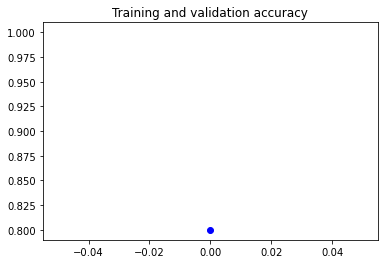

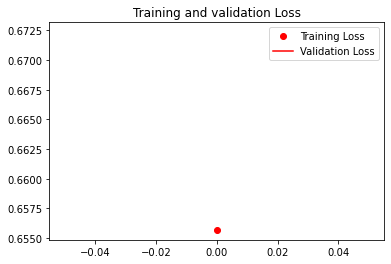

In [34]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')

plt.legend()
plt.show()


In [38]:
# 看起来过拟合了，怎么解决呢？
# 最直接就是从数据下手，2W数据量还是不够，深度学习数据越多越好
# 数据增强 Data Augmentation
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
import os
import glob
import numpy as np


In [64]:
# 展示输入数据
def print_result(path):
    name_list = glob.glob(path)
    fig = plt.figure(figsize=(12,16))
    for i in range(3):
        img = Image.open(name_list[i])
        sub_img = fig.add_subplot(131 + i)
        sub_img.imshow(img)

In [65]:
img_path = './tmp/catdog/train/cat/*'
in_path = './tmp/catdog/train/'
out_path = './tmp/catdog/output/'
name_list = glob.glob(img_path)
name_list


['./tmp/catdog/train/cat\\cat1.jpeg',
 './tmp/catdog/train/cat\\cat10.jpeg',
 './tmp/catdog/train/cat\\cat2.jpeg',
 './tmp/catdog/train/cat\\cat3.jpeg',
 './tmp/catdog/train/cat\\cat4.jpeg',
 './tmp/catdog/train/cat\\cat5.jpeg',
 './tmp/catdog/train/cat\\cat6.jpeg',
 './tmp/catdog/train/cat\\cat7.jpeg',
 './tmp/catdog/train/cat\\cat8.jpeg',
 './tmp/catdog/train/cat\\cat9.jpeg']

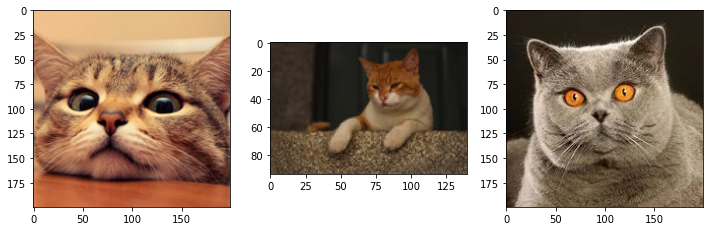

In [66]:
print_result(img_path)

In [67]:
# 指定target_size后素有图像都变为相同大小
datagen = image.ImageDataGenerator()
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False, save_to_dir=out_path+'resize',
                                      save_prefix='gen', target_size = (224,224))

Found 20 images belonging to 2 classes.


In [68]:
for i in range(3):
    gen_data.next()

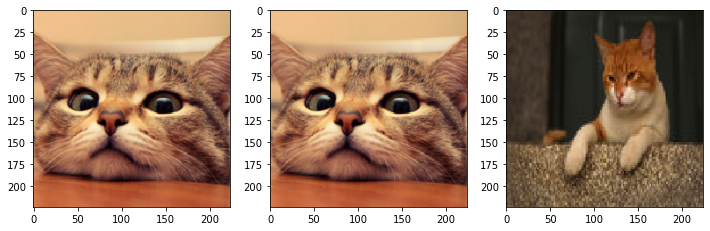

In [69]:
print_result(out_path+'resize/*')

In [71]:
# 角度旋转
datagen = image.ImageDataGenerator(rotation_range=45)
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1, class_mode=None, shuffle=True, target_size=(224,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1,  shuffle=False, save_to_dir=out_path+'rotation_range',
                                       save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


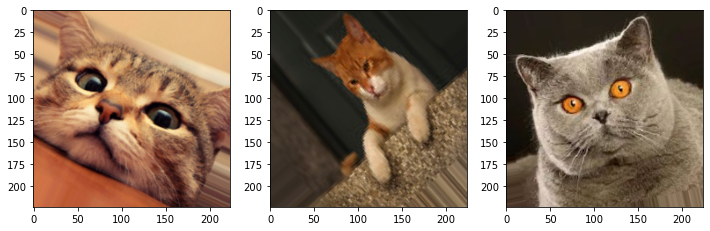

In [73]:
print_result(out_path+'rotation_range/*')

In [81]:
# channel,  featurewise, fill_mode, horizontal. nearest, rescale, resize, 
# rotation_range, shear, shift, shift2, vertical_flip, zoom, zoom2
# 平移交换 shift
datagen = image.ImageDataGenerator(width_shift_range=0.5, height_shift_range=0.5)
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1,  class_mode=None, shuffle=True, target_size=(22,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False,
                                       save_to_dir=out_path+'shift',save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


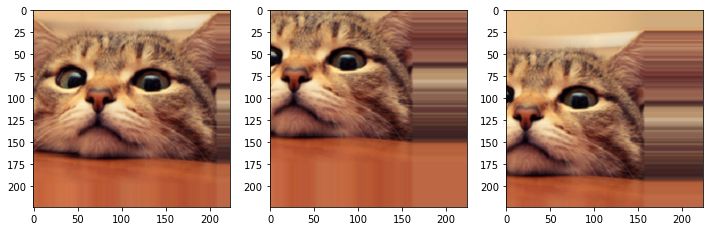

In [82]:
print_result(out_path+'shift/*')

In [83]:
# 缩放 zoom
datagen = image.ImageDataGenerator(zoom_range=0.5)
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1,  class_mode=None, shuffle=True, target_size=(22,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False,
                                       save_to_dir=out_path+'zoom',save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


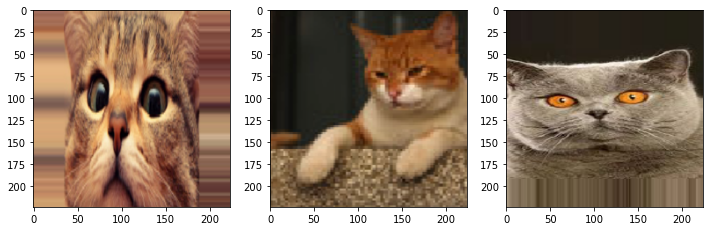

In [84]:
print_result(out_path+'zoom/*')

In [85]:
# channel shift 对颜色通道里的值进行变换
datagen = image.ImageDataGenerator(channel_shift_range=0.5)
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1,  class_mode=None, shuffle=True, target_size=(22,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False,
                                       save_to_dir=out_path+'channel',save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


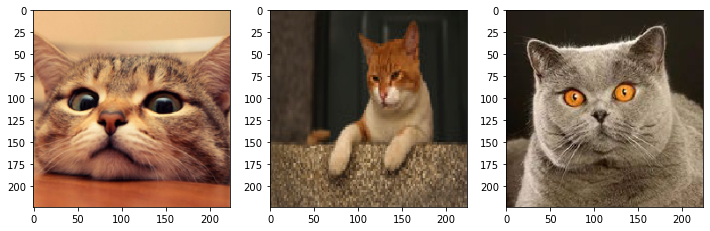

In [86]:
print_result(out_path+'channel/*')

In [87]:
# horizontal
datagen = image.ImageDataGenerator(horizontal_flip=True)
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1,  class_mode=None, shuffle=True, target_size=(22,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False,
                                       save_to_dir=out_path+'horizontal_flip',save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


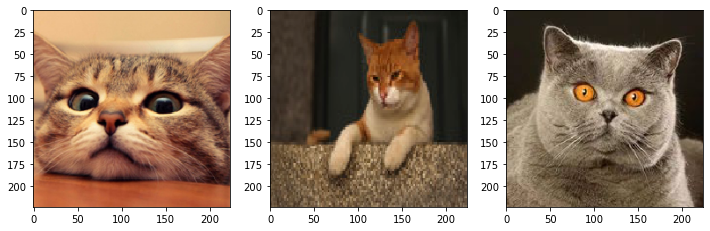

In [88]:
print_result(out_path+'horizontal_flip/*')

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


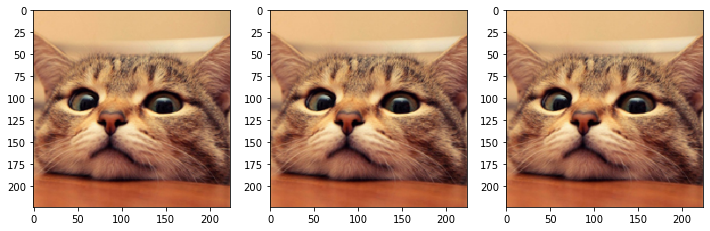

In [100]:
# rescale 1/255将像素点从0-255压缩到0到1之间，将1改为2，就是0到2之间，
# 这个0到1 是很重要的，很多的计算都是基于这个来做的
datagen = image.ImageDataGenerator(rescale=1/255)
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1,  class_mode=None, shuffle=True, target_size=(22,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False,
                                       save_to_dir=out_path+'rescale',save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

# print(gen_data.next())
print_result(out_path+'rescale/*')    

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


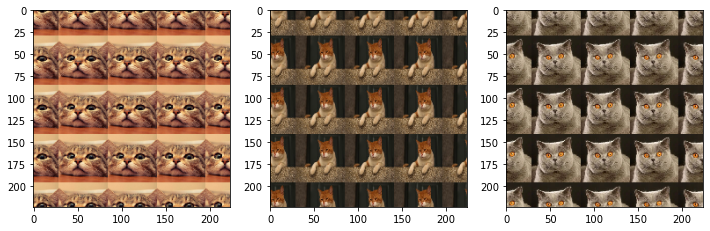

In [102]:
# 填充 fill_mode constant nearest reflect wrap
datagen = image.ImageDataGenerator(fill_mode='wrap', zoom_range=[4,4])
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1,  class_mode=None, shuffle=True, target_size=(22,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False,
                                       save_to_dir=out_path+'fill_mode',save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

# print(gen_data.next())
print_result(out_path+'fill_mode/*')    

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


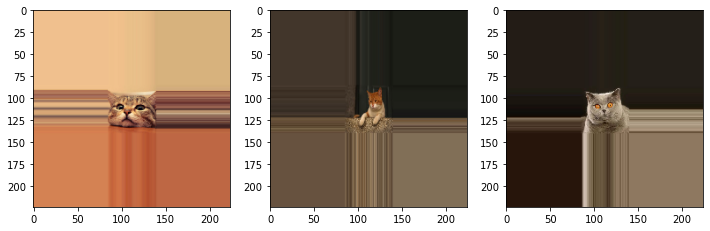

In [103]:
# nearest
datagen = image.ImageDataGenerator(fill_mode='nearest', zoom_range=[4,4])
gen = image.ImageDataGenerator()
data = gen.flow_from_directory(in_path, batch_size=1,  class_mode=None, shuffle=True, target_size=(22,224))
np_data = np.concatenate([data.next() for i in range(data.n)])
datagen.fit(np_data)
gen_data = datagen.flow_from_directory(in_path, batch_size=1, shuffle=False,
                                       save_to_dir=out_path+'nearest',save_prefix='gen', target_size=(224,224))
for i in range(3):
    gen_data.next()

# print(gen_data.next())
print_result(out_path+'nearest/*')    